In [1]:
#-------------------------------------------------------------------------------
# Paper: Sensitivity analysis and uncertainty propagation of the time to onset
#         of natural circulation in air ingress accidents
# Journal: Nuclear Engineering and Design
# Corresponding Authors: Meredith Eaheart (eaheart@umich.edu)
#                        Majdi Radaideh (radaideh@umich.edu)
# Date: September 24, 2025
#-------------------------------------------------------------------------------

In [2]:
#dependencies needed

#pip install

#SALib==1.5.1
#tensorflow==2.19.0
#scikit-learn=1.7.0
#matplotlib
#pandas
#numpy
#seaborn

In [3]:
#-------------------------------------------------
# Package Import
#-------------------------------------------------

#general pacakges
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns

#for random forests and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#for NN training
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

#for SA/UQ
from SALib.sample import finite_diff, fast_sampler, latin
from SALib.sample import morris as morris_sampler
from SALib.sample.sobol import sample
from SALib.analyze import sobol, dgsm, fast, delta, pawn, hdmr, rsa, morris
from SALib.test_functions import Ishigami
from SALib import ProblemSpec

#create the result directory if it does not exist
output_dir="mbe_results"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [4]:
#-------------------------------------------------
# Load Dataset
#-------------------------------------------------

# Load input features (drop Sample Index and Case Name)
inputs_raw = pd.read_csv("data/inputs.csv")

x = inputs_raw.drop(columns=["Sample Index", "Case Name"])

# Load outputs and isolate target variables
outputs_raw = pd.read_csv("data/outputs.csv")
y = outputs_raw[["time_to_onc", "T_after_onc"]]

# Preview
print("x shape:", x.shape)
print("y shape:", y.shape)
y.head()

x shape: (500, 8)
y shape: (500, 2)


,time_to_onc,T_after_onc
0,3323,657.0
1,2728,757.5
2,3509,700.5
3,3071,700.5
4,4434,570.5


In [5]:
#-------------------------------------------------
# Random Forest Training and validation
#-------------------------------------------------
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))

#split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

#scale inputs
scaler_x = StandardScaler()
xtrain_scaled = scaler_x.fit_transform(xtrain)
xtest_scaled = scaler_x.transform(xtest)

#train RF
rf = RandomForestRegressor(n_estimators=200, random_state=42, max_features=None)
rf.fit(xtrain_scaled, ytrain)

#predict
ytrain_pred_rf = rf.predict(xtrain_scaled)
ytest_pred_rf = rf.predict(xtest_scaled)

#evaluate
print("Random Forest Metrics")
train_rf_r2=r2_score(ytrain, ytrain_pred_rf, multioutput='raw_values')
test_rf_r2=r2_score(ytest, ytest_pred_rf, multioutput='raw_values')
test_rf_mae=mean_absolute_error(ytest, ytest_pred_rf, multioutput='raw_values')
test_rf_rmse=root_mean_squared_error(ytest, ytest_pred_rf)
print("Train R²:", train_rf_r2)
print("Test R²:", test_rf_r2)
print("Test MAE:", test_rf_mae)
print("Test RMSE:", test_rf_rmse)

Random Forest Metrics
Train R²: [0.99769887 0.99455734]
Test R²: [0.98534519 0.96405982]
Test MAE: [63.9755 24.2335]
Test RMSE: [89.8334119  36.37343819]


In [6]:
#-------------------------------------------------
# Neural Network Training and validation
#-------------------------------------------------

#pick between train and load. Use the mode load when you have trained the surrogate and you want
# to load the best model to use for SA/UQ which saves time and reduce stochastity of retraining.
# use model train for the first time training to create the best model
model_mode = 'load'

#scale outputs for NN
scaler_y_nn = MinMaxScaler()
ytrain_scaled_nn = scaler_y_nn.fit_transform(ytrain)
ytest_scaled_nn = scaler_y_nn.transform(ytest)

# Callbacks
checkpoint_path = "./best_nn_model.keras"  #save the best model based on validation MAE to use for prediction


if model_mode == 'train':
  #train mode
  model = Sequential()

  #Layer 0
  model.add(Dense(50, activation='relu', kernel_initializer='normal', input_shape=(xtrain.shape[1],)))
  #Layer 1
  model.add(Dropout(0.25))
  #Layer 2
  model.add(Dense(50, activation='relu', kernel_initializer='normal'))
  #Layer 3
  model.add(Dense(50, activation='relu', kernel_initializer='normal'))
  model.add(Dense(ytrain.shape[1], activation='linear', kernel_initializer='normal'))

  model.summary()

  #compile the model
  model.compile(
      loss='mean_absolute_error',
      metrics=['mean_absolute_error'],
      optimizer=Adam(learning_rate=1e-3)
  )

  callbacks = [
      ReduceLROnPlateau(                         #decay learning rate when no improvement happens after 5 epochs
          monitor='val_mean_absolute_error',
          factor=0.9,
          patience=5,
          verbose=1,
          mode='min',
          min_lr=1e-6
      ),
      ModelCheckpoint(
          filepath=checkpoint_path,             #save best model when val MAE improves, use best model for prediction
          monitor='val_mean_absolute_error',
          save_best_only=True,
          mode='min',
          verbose=1
      )
  ]

  # Train the model
  history = model.fit(
      xtrain_scaled, ytrain_scaled_nn,
      validation_split=0.2,
      epochs=200,
      batch_size=8,
      verbose=1,
      callbacks=callbacks
  )

elif model_mode == 'load':

  # Load best model
  model = load_model(checkpoint_path)

else:
  raise ValueError("Error: you must pick either 'train' or 'load' for model_mode")

# Predict and inverse transform
ytrain_pred_nn = scaler_y_nn.inverse_transform(model.predict(xtrain_scaled))
ytest_pred_nn  = scaler_y_nn.inverse_transform(model.predict(xtest_scaled))

# Evaluate
print("Neural Network Metrics")
train_nn_r2=r2_score(ytrain, ytrain_pred_nn, multioutput='raw_values')
test_nn_r2=r2_score(ytest, ytest_pred_nn, multioutput='raw_values')
test_nn_mae=mean_absolute_error(ytest, ytest_pred_nn, multioutput='raw_values')
test_nn_rmse=root_mean_squared_error(ytest, ytest_pred_nn)
print("Train R²:", train_nn_r2)
print("Test R²:", test_nn_r2)
print("Test MAE:", test_nn_mae)
print("Test RMSE:", test_nn_rmse)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
Neural Network Metrics
Train R²: [0.9819081 0.9949484]
Test R²: [0.9864002  0.99277806]
Test MAE: [64.02399  10.101668]
Test RMSE: [86.53944  16.304993]


/tmp/ipython-input-2060428789.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: float(f"{x:.3g}"))


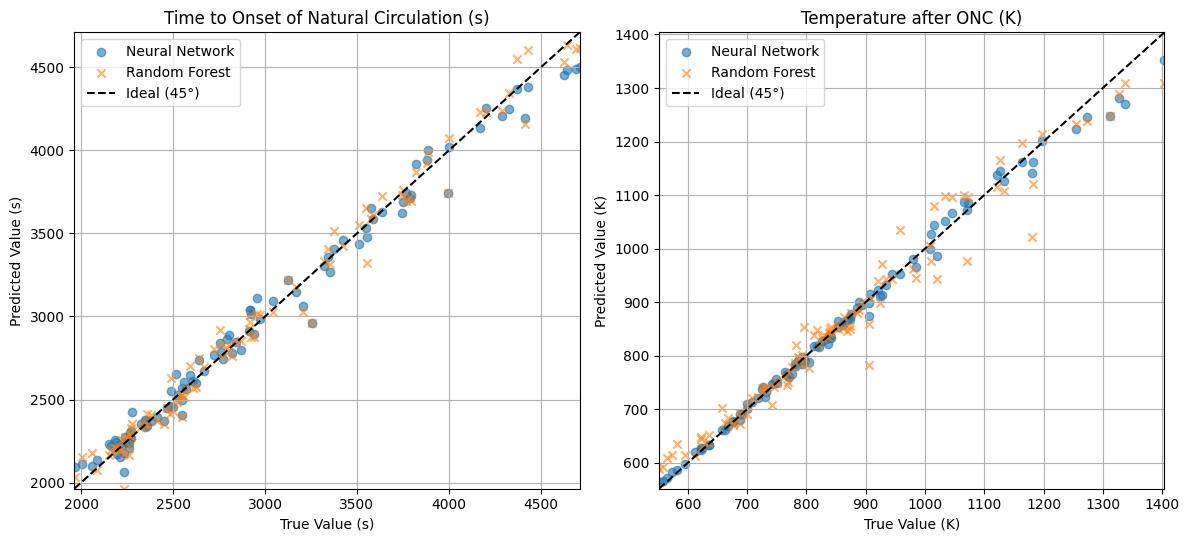

Metric,Test R²,Test MAE,Test RMSE
Neural Network: Time to Onset of Natural Circulation (s),0.986,64.0,86.5
Neural Network: Temperature after ONC (K),0.993,10.1,16.3
Random Forests: Time to Onset of Natural Circulation (s),0.985,64.0,89.8
Random Forests: Temperature after ONC (K),0.964,24.2,36.4


In [7]:
#---------------------------------------------------
# Surrogate Postprocessing
#-------------------------------------------------

#--Create surrogate diagonal plots and collect metrics in CSV

# Combine all metrics into one DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Test R²', 'Test MAE', 'Test RMSE'],
    'Neural Network: Time to Onset of Natural Circulation (s)': [test_nn_r2[0], test_nn_mae[0], test_nn_rmse[0]],
    'Neural Network: Temperature after ONC (K)': [test_nn_r2[1], test_nn_mae[1], test_nn_rmse[1]],
    'Random Forests: Time to Onset of Natural Circulation (s)': [test_rf_r2[0], test_rf_mae[0], test_rf_rmse[0]],
    'Random Forests: Temperature after ONC (K)': [test_rf_r2[1], test_rf_mae[1], test_rf_rmse[1]]
})

# Set the Output as index
metrics_df.set_index('Metric', inplace=True)

metrics_df=metrics_df.T

#round to three significant digits for easier reporting
metrics_df = metrics_df.applymap(lambda x: float(f"{x:.3g}"))

# Export to CSV
metrics_df.to_csv(f'{output_dir}/surrogate_metrics.csv')
metrics_df


#--Create diagonal plots for the test data of the two models

# Create figure with 1 row and 2 columns (two subplots)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# --- Output 1 ---
ax1.scatter(ytest.values[:, 0], ytest_pred_nn[:, 0], label='Neural Network', alpha=0.6, marker='o')
ax1.scatter(ytest.values[:, 0], ytest_pred_rf[:, 0], label='Random Forest', alpha=0.6, marker='x')

min_val_1 = min(ytest.values[:, 0].min(), ytest_pred_nn[:, 0].min(), ytest_pred_rf[:, 0].min())
max_val_1 = max(ytest.values[:, 0].max(), ytest_pred_nn[:, 0].max(), ytest_pred_rf[:, 0].max())
ax1.plot([min_val_1, max_val_1], [min_val_1, max_val_1], 'k--', label='Ideal (45°)')
ax1.set_xlim(min_val_1, max_val_1)
ax1.set_ylim(min_val_1, max_val_1)

ax1.set_title('Time to Onset of Natural Circulation (s)')
ax1.set_xlabel('True Value (s)')
ax1.set_ylabel('Predicted Value (s)')
ax1.legend()
ax1.grid(True)

# --- Output 2 ---
ax2.scatter(ytest.values[:, 1], ytest_pred_nn[:, 1], label='Neural Network', alpha=0.6, marker='o')
ax2.scatter(ytest.values[:, 1], ytest_pred_rf[:, 1], label='Random Forest', alpha=0.6, marker='x')

min_val_2 = min(ytest.values[:, 1].min(), ytest_pred_nn[:, 1].min(), ytest_pred_rf[:, 1].min())
max_val_2 = max(ytest.values[:, 1].max(), ytest_pred_nn[:, 1].max(), ytest_pred_rf[:, 1].max())
ax2.plot([min_val_2, max_val_2], [min_val_2, max_val_2], 'k--', label='Ideal (45°)')
ax2.set_xlim(min_val_2, max_val_2)
ax2.set_ylim(min_val_2, max_val_2)

ax2.set_title('Temperature after ONC (K)')
ax2.set_xlabel('True Value (K)')
ax2.set_ylabel('Predicted Value (K)')
ax2.legend()
ax2.grid(True)

# Adjust layout and save one combined figure
#fig.suptitle('Predicted vs. True Values for NN and RF Models', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'{output_dir}/surrogate_diagonal.png', dpi=300, bbox_inches='tight')
plt.show()

#show metrics table
metrics_df

In [8]:
#--------------------------------------
# Variance-based Sensitivity Analysis
#---------------------------------------

#Select which model and output to perform the sensitivity analyses
#Repeat this for the rf and nn
#And for both the time to ONC and the T after ONC

#Change these to the following perturbations then run the below blocks: rf & 0, rf & 1, model & 0, and model & 1
select_model = model #choose which model you want to use here 'model' for the NN and then 'rf' for random forest
output_index = 1 #0 = Time to ONC, 1 = T after ONC

#Prepare to autolabel the plots
y_names = ["Time to Onset of Natural Circulation (s)", "Temperature after ONC (K)"] #output names- used for other parts of the code later too
output_label = y_names[output_index]
output_tags = {
    0: "time_onc",
    1: "T_after_onc"
}
output_tag = output_tags[output_index]


model_name = "Random Forest" if select_model == rf else "Neural Network"
model_tag = "rf" if select_model == rf else "nn"

In [9]:
#----------------------------------
#sobol sensitivity
#---------------------------------

#From samplers I think I just need sobol?
def gen_sobol(variable_names,upper,lower,N):

    # Extract the number of variables from the DataFrame
    num_vars = len(variable_names)
    # Create a list of lower and upper bounds for each variable
    low_up = [[lower[i], upper[i]] for i in range(num_vars)]

    problem = {
        'num_vars': num_vars,
        'names': variable_names,
        'bounds': low_up
    }

    # Generate Sobol sequences
    param_values = pd.DataFrame(sample(problem, N), columns=variable_names)

    return param_values

#Load parameter ranges
param_ranges = pd.read_csv("./data/param_ranges.csv")
variable_names = param_ranges['Parameter'].tolist()
lower = param_ranges['Lower bound'].values
upper = param_ranges['Upper bound'].values
n_sob = 8192

#generate the sobol samples
param_values = gen_sobol(variable_names, upper, lower, n_sob)

#prepare the x and y values for the sobol
x_sobol = param_values.values
x_sobol_scaled = scaler_x.transform(pd.DataFrame(x_sobol, columns = variable_names))
y_sobol_scaled = select_model.predict(x_sobol_scaled)
y_sobol = scaler_y_nn.inverse_transform(y_sobol_scaled)
y_sobol = pd.DataFrame(y_sobol, columns=["Time to ONC (s)", "Temperature after ONC (K)"])

# Create a list of lower and upper bounds for each variable
nx = x_sobol_scaled.shape[1]
low_up = [[lower[i], upper[i]] for i in range(nx)]

problem = {
    'num_vars': nx,
    'names': variable_names,
    'bounds': low_up,
    'groups': ['Group_{num}'.format(num=k) for k in range(1,nx+1)],
}

Si = sobol.analyze(problem, y_sobol.iloc[:,output_index].values)

#Sobol data
Sobol_Si = pd.DataFrame([Si['S1'], Si['S1_conf'], Si['ST'], Si['ST_conf']], columns=variable_names, index=['S1', 'S1_conf', 'ST', 'ST_conf']).T
#--------------------------------------------------------

4608/4608 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


In [10]:
#-----------------------------------------------------
# Fourier Amplitude Sensitivity Test (FAST)
#-----------------------------------------------------

ny = y.shape[1]  #number of outputs

Xfast = pd.DataFrame(fast_sampler.sample(problem, 5000), columns=variable_names)

Xfast_scaled = scaler_x.transform(Xfast)
Yfast_scaled = select_model.predict(Xfast_scaled)

#If using nn, inverse transform outputs
if select_model == model:
    Yfast = scaler_y_nn.inverse_transform(Yfast_scaled)
else:
    Yfast = Yfast_scaled

Yfast = pd.DataFrame(Yfast, columns=y_names)

#Run FAST sensitivity analysis on output (0 = time to ONC, 1 = T after ONC)
S_fast = fast.analyze(problem, Yfast.iloc[:, output_index].values, num_resamples=2000, print_to_console=False)

#FAST data
FAST_Si = pd.DataFrame([S_fast['S1'], S_fast['S1_conf'], S_fast['ST'], S_fast['ST_conf']],
                       columns=variable_names,
                       index=['S1', 'S1_conf', 'ST', 'ST_conf']).T

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [11]:
#--------------------------------------------------------
#Morris Screening
#-----------------------------------------------------
num_levels=10
Xmorris=pd.DataFrame(morris_sampler.sample(problem, N=10000,
                                           num_levels=num_levels), columns=variable_names)

Xmorris_scaled = scaler_x.transform(Xmorris)
Ymorris_scaled = select_model.predict(Xmorris_scaled)

#If using nn, inverse transform outputs
if select_model == model:
    Ymorris = scaler_y_nn.inverse_transform(Ymorris_scaled)
else:
    Ymorris = Ymorris_scaled

Ymorris = pd.DataFrame(Ymorris, columns=y_names)

S_morris = morris.analyze(problem, Xmorris.values, Ymorris.iloc[:,output_index].values,
                          conf_level=0.95, num_levels=num_levels, scaled= True)
#Morris data
MORRIS_Si = pd.DataFrame([S_morris['mu'], S_morris['sigma'], S_morris['mu_star'], S_morris['mu_star_conf']],
                         columns=variable_names,
                         index=['$\mu$', 'mu_conf', '$\mu^*$', 'mu_star_conf']).T

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3985934523.py:24: SyntaxWarning: invalid escape sequence '\m'
  index=['$\mu$', 'mu_conf', '$\mu^*$', 'mu_star_conf']).T
/tmp/ipython-input-3985934523.py:24: SyntaxWarning: invalid escape sequence '\m'
  index=['$\mu$', 'mu_conf', '$\mu^*$', 'mu_star_conf']).T


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 3s 895us/step


In [12]:
#---------------------------------------------------------------------------------------------
# Regional Sensitivity Analysis
#-----------------------------------------------------
Xrsa=pd.DataFrame(latin.sample(problem, 50000), columns=variable_names)

Xrsa_scaled = scaler_x.transform(Xrsa)
Yrsa_scaled = select_model.predict(Xrsa_scaled)

#If using nn, inverse transform outputs
if select_model == model:
    Yrsa = scaler_y_nn.inverse_transform(Yrsa_scaled)
else:
    Yrsa = Yrsa_scaled

Yrsa = pd.DataFrame(Yrsa, columns=y_names)

S_rsa= rsa.analyze(problem, Xrsa.values, Yrsa.iloc[:,output_index].values, bins=100)

#determine parameter sensitivity by taking the mean and standard deviation over all bins
rsa_sum=[]
for key in S_rsa['names']:
    rsa_sum.append(np.sum(S_rsa[key]))

#normalize the coefficient (most sensitive parameter will have 1.0 coefficient)
rsa_normalized=np.array(rsa_sum)/np.max(rsa_sum)

#RSA data
RSA_Si = pd.DataFrame([rsa_normalized],
                      columns=variable_names,
                      index=['RSA']).T

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 965us/step


<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3318772500.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax=MORRIS_Si[['$\mu$','$\mu^*$']].plot(kind='bar',
/tmp/ipython-input-3318772500.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax=MORRIS_Si[['$\mu$','$\mu^*$']].plot(kind='bar',


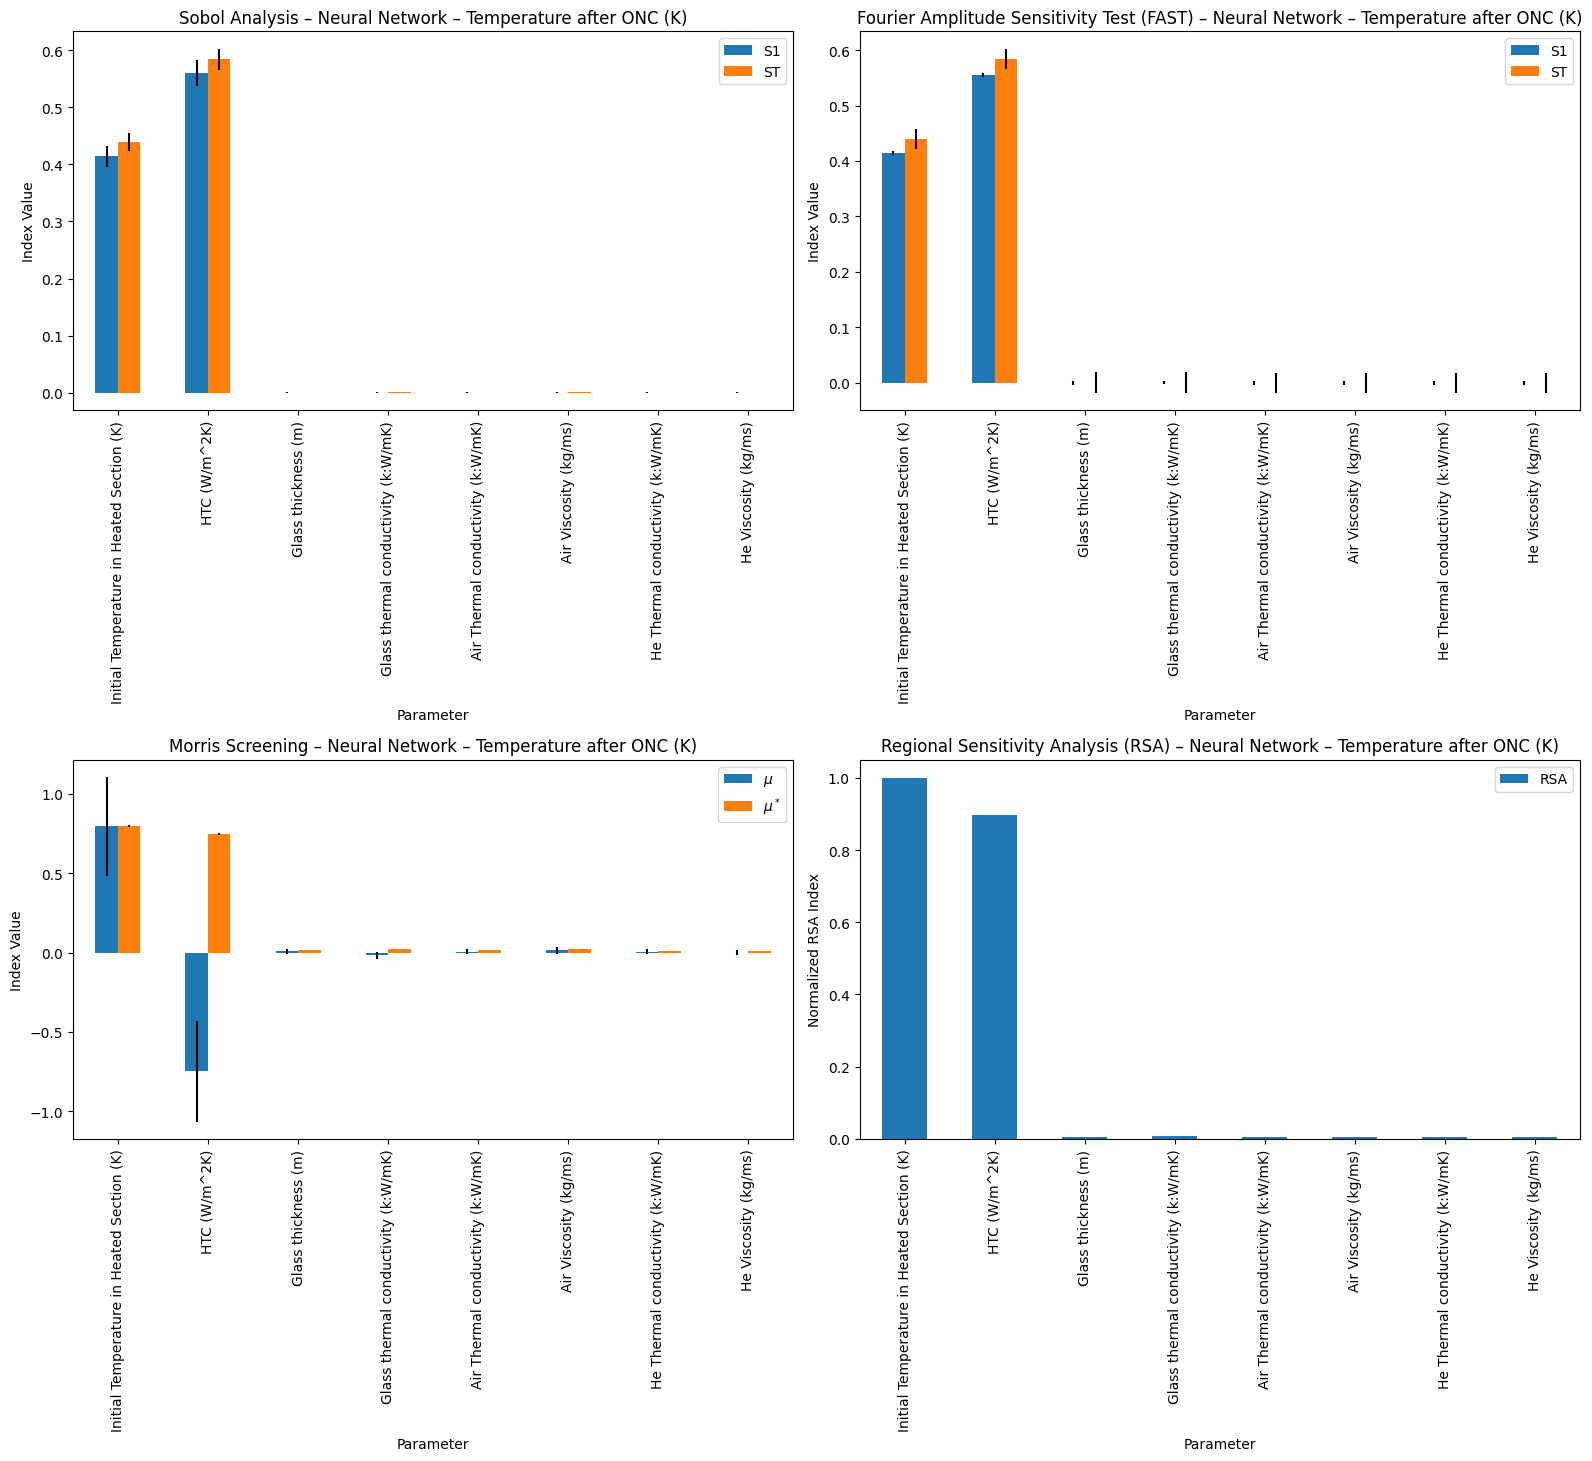

In [13]:
#------------------------------------------------------
#SA Postprocessing
#------------------------------------------------------

#Plotting Block for all four SA methods in one Subplot

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

#sobol plotting
ax=Sobol_Si[['S1','ST']].plot(kind='bar',
                              yerr=Sobol_Si[['S1_conf', 'ST_conf']].T.values,
                              ax=axes[0, 0],
                              title=f"Sobol Analysis – {model_name} – {output_label}")   #plot with error bars
axes[0, 0].set_xlabel("Parameter"); axes[0, 0].set_ylabel("Index Value")

#fast plotting
ax=FAST_Si[['S1','ST']].plot(kind='bar',
                             yerr=FAST_Si[['S1_conf', 'ST_conf']].T.values,
                             ax=axes[0, 1],
                             title=f'Fourier Amplitude Sensitivity Test (FAST) – {model_name} – {output_label}')   #plot with error bars
axes[0, 1].set_xlabel("Parameter"); axes[0, 1].set_ylabel("Index Value")

#Morris plotting
ax=MORRIS_Si[['$\mu$','$\mu^*$']].plot(kind='bar',
                                       yerr=MORRIS_Si[['mu_conf', 'mu_star_conf']].T.values,
                                       ax=axes[1, 0],
                                       title=f'Morris Screening – {model_name} – {output_label}')   #plot with error bars
axes[1, 0].set_xlabel("Parameter"); axes[1, 0].set_ylabel("Index Value")

#RSA plotting
ax = RSA_Si[['RSA']].plot(kind='bar',
                          ax=axes[1, 1],
                          title=f'Regional Sensitivity Analysis (RSA) – {model_name} – {output_label}')   #plot with error bars
axes[1, 1].set_xlabel("Parameter")
axes[1, 1].set_ylabel("Normalized RSA Index")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave room for suptitle
plt.savefig(f'{output_dir}/sa_results_{model_tag}_{output_tag}.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
Sobol_FAST_Si=pd.concat([Sobol_Si, FAST_Si], axis=1)
Sobol_FAST_Si.to_csv(f'{output_dir}/sobol_fast_{model_tag}_{output_tag}.csv', index=True)
MORRIS_RSSA_Si=pd.concat([MORRIS_Si, RSA_Si], axis=1)
MORRIS_RSSA_Si.to_csv(f'{output_dir}/morris_rsa_{model_tag}_{output_tag}.csv', index=True)

In [15]:
#---------------------------------
#Uncertainty Quantification (UQ)
#----------------------------------

#1- Global uncertainty propagation:
#Given the range of perturbation in the input parameters, how much this
#leads to uncertainty in the output?

#note that 10,000 samples are used here to ensure statistics are converging which is much
#larger than the 1000 samples that we generated for the surrogate from CFD due to costs.
global_samples= np.random.uniform(low=lower, high=upper, size=(10000, nx))

#forward pass into the surrogate, NN selected here to simplify the analysis

global_samples=scaler_x.transform(global_samples)
global_uq=model.predict(global_samples)
global_uq=scaler_y_nn.inverse_transform(global_uq)


#2- Local uncertainty propagation:
#Isolate the weak parameters from perturbations,
#and replot the histogram to observe the spread of the outputs. The weak parameters are fixed to their mean value

#-------- Time to ONC -----------

local_samples_t_onc= np.random.uniform(low=lower, high=upper, size=(10000, nx))

#for time to ONC, only change the temperature, first column
local_samples_t_onc[:,1:] = (lower[1:] + upper[1:])/2

#forward pass into the model
local_samples_t_onc=scaler_x.transform(local_samples_t_onc)
local_uq=model.predict(local_samples_t_onc)
local_uq=scaler_y_nn.inverse_transform(local_uq)

#-------- T after ONC -----------

local_samples_T_after_onc= np.random.uniform(low=lower, high=upper, size=(10000, nx))
#for T after ONC, only change the temperature and HTC, first and second columns
local_samples_T_after_onc[:,2:] = (lower[2:] + upper[2:])/2

#forward pass into the model
local_samples_T_after_onc=scaler_x.transform(local_samples_T_after_onc)
local_uq_TONC =model.predict(local_samples_T_after_onc)
local_uq_TONC=scaler_y_nn.inverse_transform(local_uq_TONC)

#replace the second column in local_uq with the correct one from local_uq2

local_uq[:,1] = local_uq_TONC[:,1].copy()

115/313 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
158/313 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
164/313 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


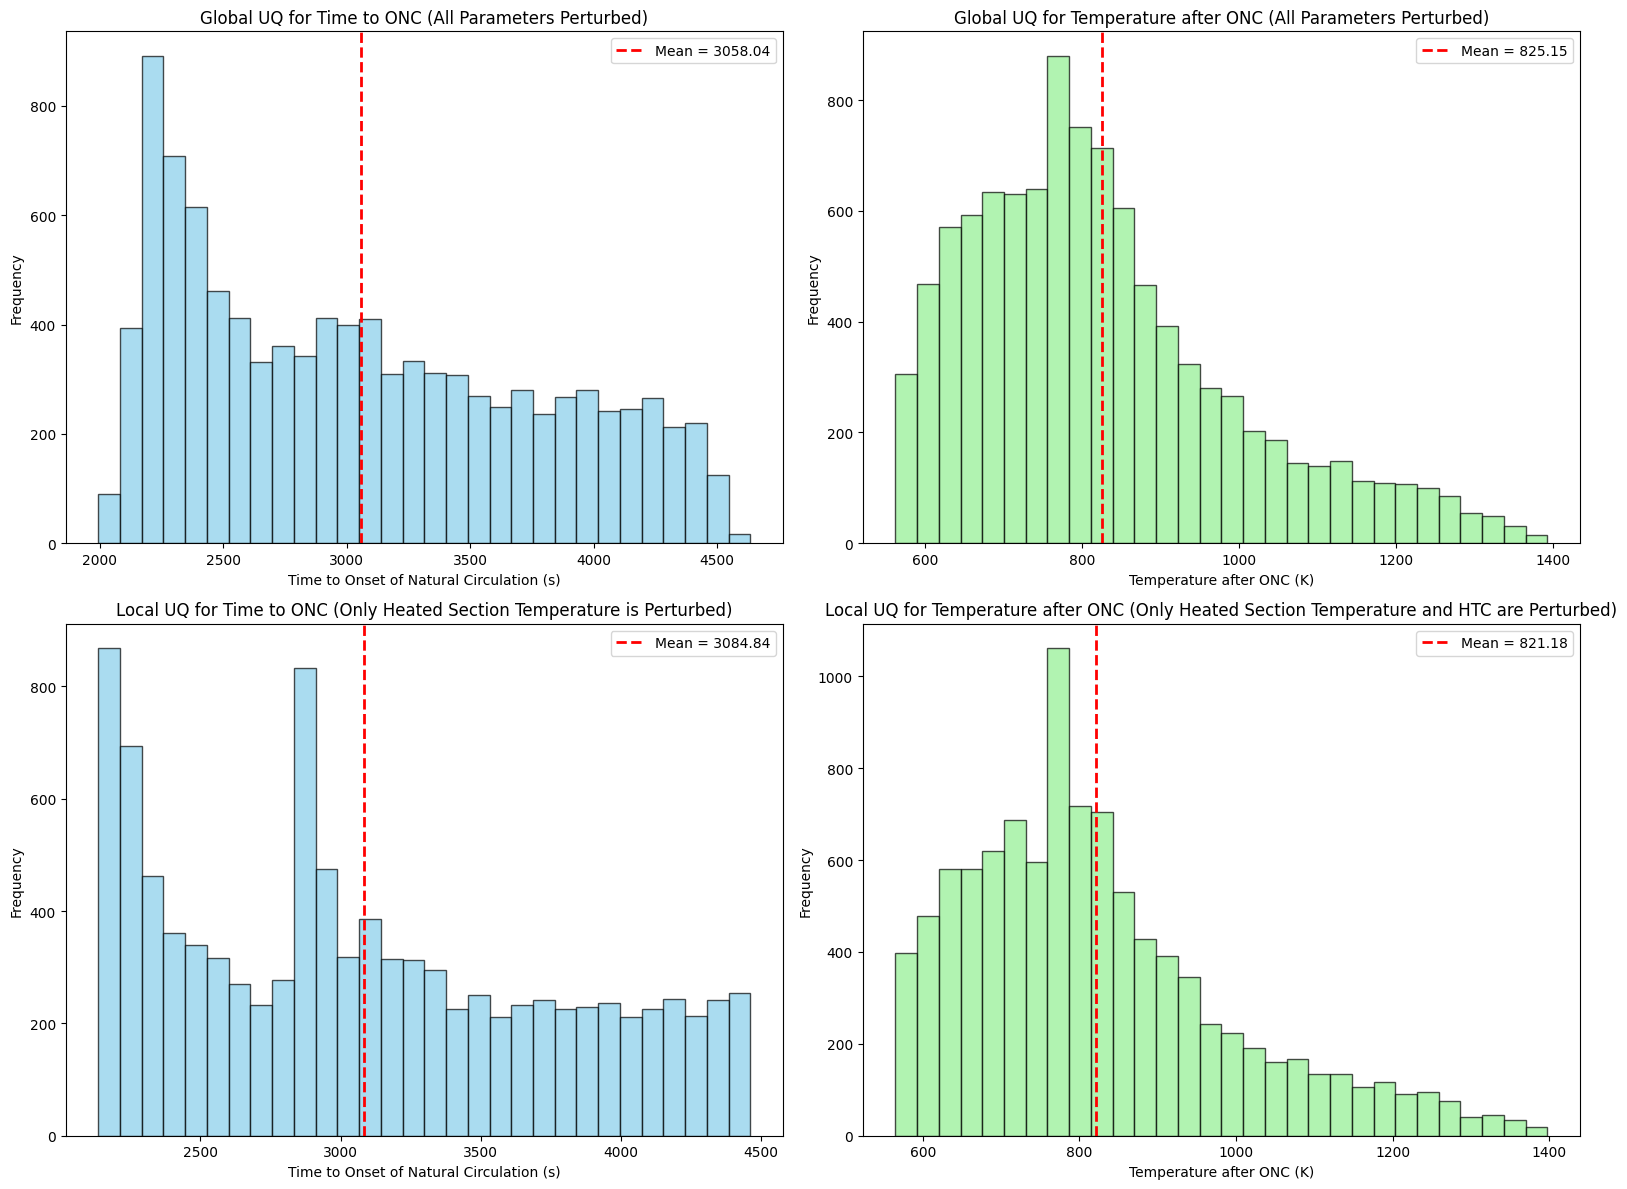

In [16]:
#---------------------------------
#UQ postprocessing
#---------------------------------

# Compute means
global_means = global_uq.mean(axis=0)

local_means = local_uq.mean(axis=0)

# Plot
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# global UQ time ONC
axs[0, 0].hist(global_uq[:, 0], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axs[0, 0].axvline(global_means[0], color='red', linestyle='--', linewidth=2, label=f'Mean = {global_means[0]:.2f}')
axs[0, 0].set_title('Global UQ for Time to ONC (All Parameters Perturbed)')
axs[0, 0].set_xlabel('Time to Onset of Natural Circulation (s)')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend()

# global UQ, T after ONC
axs[0, 1].hist(global_uq[:, 1], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axs[0, 1].axvline(global_means[1], color='red', linestyle='--', linewidth=2, label=f'Mean = {global_means[1]:.2f}')
axs[0, 1].set_title('Global UQ for Temperature after ONC (All Parameters Perturbed)')
axs[0, 1].set_xlabel('Temperature after ONC (K)')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# local UQ time to ONC
axs[1, 0].hist(local_uq[:, 0], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axs[1, 0].axvline(local_means[0], color='red', linestyle='--', linewidth=2, label=f'Mean = {local_means[0]:.2f}')
axs[1, 0].set_title('Local UQ for Time to ONC (Only Heated Section Temperature is Perturbed)')
axs[1, 0].set_xlabel('Time to Onset of Natural Circulation (s)')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend()

# local UQ, T after ONC
axs[1, 1].hist(local_uq[:, 1], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axs[1, 1].axvline(local_means[1], color='red', linestyle='--', linewidth=2, label=f'Mean = {local_means[1]:.2f}')
axs[1, 1].set_title('Local UQ for Temperature after ONC (Only Heated Section Temperature and HTC are Perturbed)')
axs[1, 1].set_xlabel('Temperature after ONC (K)')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend()

# Layout
plt.tight_layout()
plt.savefig(f'{output_dir}/uq_hist.png', dpi=300, bbox_inches='tight')
plt.show()


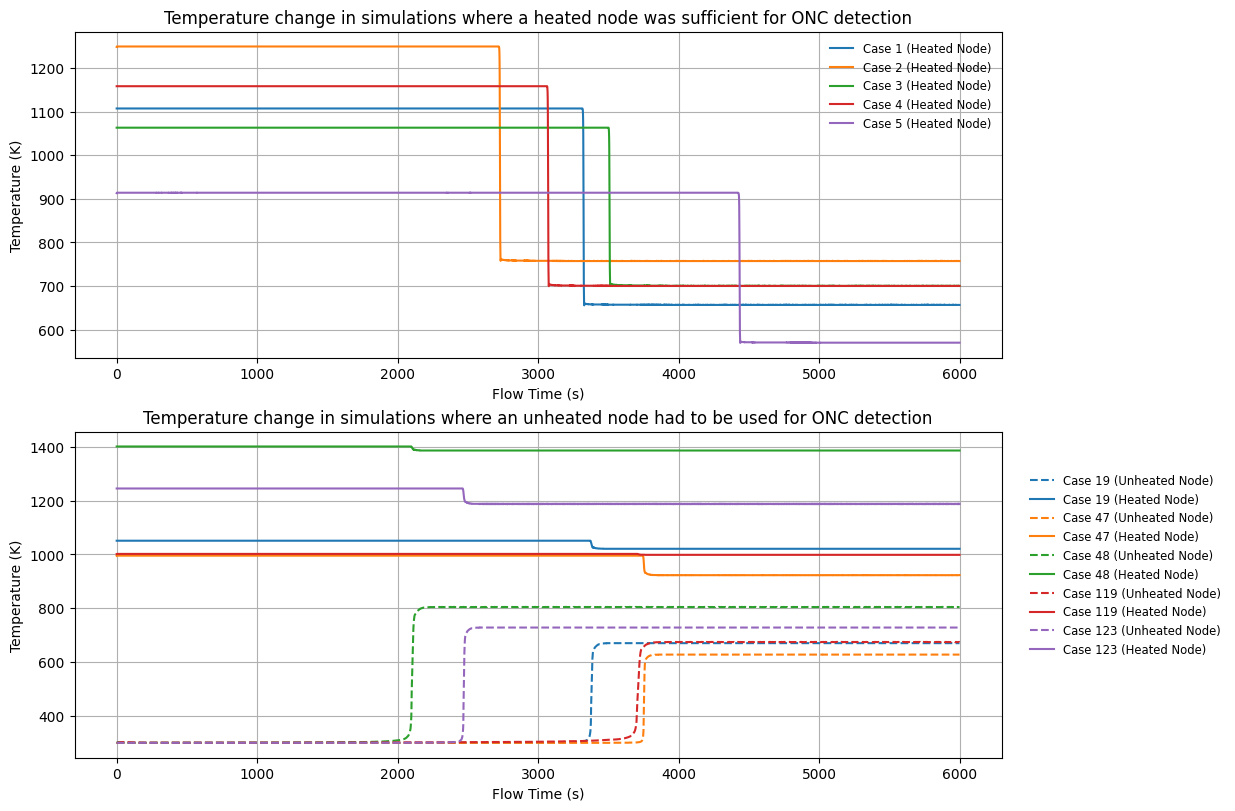

In [17]:
##---------------------------------
# ONC Detection (auxiliary plot)
#---------------------------------
#This is additional postprocessing plot of ONC data for clarification (this is used for the paper for selected simulations)

heated_data=pd.read_csv('./data/heated_data.csv')   #these csv files were pre-generated from the tensors
unheated_data=pd.read_csv('./data/unheated_data.csv') #these csv files were pre-generated from the tensors

colors = plt.get_cmap('tab10').colors[:5]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)

# --- Top subplot: Heated nodes ---
heated_lines = heated_data.plot(
    x='Flow Time',
    y=['Case 1 (Heated Node)', 'Case 2 (Heated Node)', 'Case 3 (Heated Node)',
       'Case 4 (Heated Node)', 'Case 5 (Heated Node)'],
    ax=axes[0],
    color=colors,
    legend=False  # Disable automatic legend here
)
axes[0].set_xlabel('Flow Time (s)')
axes[0].set_ylabel('Temperature (K)')
axes[0].set_title('Temperature change in simulations where a heated node was sufficient for ONC detection')
axes[0].grid(True)

# Manually add legend INSIDE the top subplot (top-right corner)
handles_top, labels_top = axes[0].get_legend_handles_labels()
axes[0].legend(handles_top, labels_top, loc='upper right', fontsize='small', frameon=False)

# --- Bottom subplot: Unheated nodes ---
legend_handles = []
legend_labels = []

for i in range(5):
    l1, = axes[1].plot(unheated_data['Flow Time'], unheated_data.iloc[:, i+1],
                       label=f'{unheated_data.columns[i+1]}', color=colors[i], linestyle='--')
    l2, = axes[1].plot(unheated_data['Flow Time'], unheated_data.iloc[:, i+6],
                       label=f'{unheated_data.columns[i+6]}', color=colors[i], linestyle='-')
    legend_handles.extend([l1, l2])
    legend_labels.extend([l1.get_label(), l2.get_label()])

axes[1].set_xlabel('Flow Time (s)')
axes[1].set_ylabel('Temperature (K)')
axes[1].set_title('Temperature change in simulations where an unheated node had to be used for ONC detection')
axes[1].grid(True)

# Legend OUTSIDE the bottom subplot, aligned on right and a bit lower
fig.legend(legend_handles, legend_labels, loc='center left',
           bbox_to_anchor=(1.02, 0.3), borderaxespad=0., fontsize='small', frameon=False)

plt.savefig(f'{output_dir}/cfd_onc_detection.png', dpi=300, bbox_inches='tight')

plt.show()


In [18]:
# =======================================
# Deep Ensemble (Time consuming block)
# =======================================

model_mode = 'train'

# ---- Scaling (same as your block) ----
scaler_y_nn = MinMaxScaler()
ytrain_scaled_nn = scaler_y_nn.fit_transform(ytrain)
ytest_scaled_nn  = scaler_y_nn.transform(ytest)

# ---------- Config ----------
N_ENSEMBLE   = 10
BASE_CKPT    = "./best_nn_member"  # files: best_nn_member0.keras ... best_nn_member9.keras
EPOCHS       = 20    #increasing this number will increase computing time significantly for this block
BATCH_SIZE   = 8
VAL_SPLIT    = 0.2
VERBOSE_FIT  = 1
SEEDS        = list(range(N_ENSEMBLE))  # different seeds for diversity

def build_member(input_dim, output_dim):
    m = Sequential()
    m.add(Dense(50, activation='relu', kernel_initializer='normal', input_shape=(input_dim,)))
    m.add(Dropout(0.25))
    m.add(Dense(50, activation='relu', kernel_initializer='normal'))
    m.add(Dense(50, activation='relu', kernel_initializer='normal'))
    m.add(Dense(output_dim, activation='linear', kernel_initializer='normal'))
    m.compile(
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'],
        optimizer=Adam(learning_rate=1e-3)
    )
    return m

def train_ensemble():
    models = []
    for i in range(N_ENSEMBLE):
        np.random.seed(SEEDS[i])
        tf.keras.utils.set_random_seed(SEEDS[i])

        ckpt_path = f"{BASE_CKPT}{i}.keras"
        model = build_member(xtrain_scaled.shape[1], ytrain_scaled_nn.shape[1])

        callbacks = [
            ReduceLROnPlateau(
                monitor='val_mean_absolute_error',
                factor=0.9,
                patience=5,
                verbose=1,
                mode='min',
                min_lr=1e-6
            ),
            ModelCheckpoint(
                filepath=ckpt_path,
                monitor='val_mean_absolute_error',
                save_best_only=True,
                mode='min',
                verbose=1
            )
        ]

        # Optional: bootstrap for additional diversity
        n = xtrain_scaled.shape[0]
        idx = np.random.randint(0, n, size=n)
        Xb, yb = xtrain_scaled[idx], ytrain_scaled_nn[idx]

        model.fit(
            Xb, yb,
            validation_split=VAL_SPLIT,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=VERBOSE_FIT,
            callbacks=callbacks
        )
        # Always load best weights saved by ModelCheckpoint
        model = load_model(ckpt_path)
        models.append(model)
    return models

def load_ensemble():
    models = []
    for i in range(N_ENSEMBLE):
        ckpt_path = f"{BASE_CKPT}{i}.keras"
        if not os.path.exists(ckpt_path):
            raise FileNotFoundError(f"Missing ensemble member checkpoint: {ckpt_path}")
        models.append(load_model(ckpt_path))
    return models

def ensemble_predict_members(models, X):
    preds = []
    for m in models:
        p = m.predict(X, verbose=0)
        preds.append(np.atleast_2d(p))
    # shape: (M, N, D)
    return np.stack(preds, axis=0)

def ensemble_predict_mean_std(models, X):
    P = ensemble_predict_members(models, X)      # (M, N, D)
    mean_scaled = P.mean(axis=0)                 # (N, D)
    std_scaled  = P.std(axis=0, ddof=1)          # (N, D)
    return mean_scaled, std_scaled

# ------------------------------
# Choose mode: 'train' or 'load'
# ------------------------------
if model_mode == 'train':
    ensemble_models = train_ensemble()
elif model_mode == 'load':
    ensemble_models = load_ensemble()
else:
    raise ValueError("Error: you must pick either 'train' or 'load' for model_mode")

# =========================
# Predictions + Evaluation
# =========================
# Train set
mean_tr_scaled, std_tr_scaled = ensemble_predict_mean_std(ensemble_models, xtrain_scaled)
# For MinMaxScaler, std_y = std_z / scale_
scale_back = 1.0 / scaler_y_nn.scale_
ytrain_pred_nn = scaler_y_nn.inverse_transform(mean_tr_scaled)
ytrain_std_nn  = std_tr_scaled * scale_back  # optional: per-output ensemble spread (physical units)

# Test set
mean_te_scaled, std_te_scaled = ensemble_predict_mean_std(ensemble_models, xtest_scaled)
ytest_pred_nn = scaler_y_nn.inverse_transform(mean_te_scaled)
ytest_std_nn  = std_te_scaled * scale_back

# -------- Metrics on ensemble mean --------
print("Neural Network (Deep Ensemble) Metrics")
train_nn_r2 = r2_score(ytrain, ytrain_pred_nn, multioutput='raw_values')
test_nn_r2  = r2_score(ytest,  ytest_pred_nn,  multioutput='raw_values')
test_nn_mae = mean_absolute_error(ytest, ytest_pred_nn, multioutput='raw_values')
test_nn_rmse = root_mean_squared_error(ytest, ytest_pred_nn)
print("Train R²:", train_nn_r2)
print("Test  R²:", test_nn_r2)
print("Test  MAE:", test_nn_mae)
print("Test  RMSE:", test_nn_rmse)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3075 - mean_absolute_error: 0.3075
Epoch 1: val_mean_absolute_error improved from inf to 0.17857, saving model to ./best_nn_member0.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2941 - mean_absolute_error: 0.2941 - val_loss: 0.1786 - val_mean_absolute_error: 0.1786 - learning_rate: 0.0010
Epoch 2/20
30/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1742 - mean_absolute_error: 0.1742 
Epoch 2: val_mean_absolute_error improved from 0.17857 to 0.15261, saving model to ./best_nn_member0.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1720 - mean_absolute_error: 0.1720 - val_loss: 0.1526 - val_mean_absolute_error: 0.1526 - learning_rate: 0.0010
Epoch 3/20
33/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1468 - mean_absolute_error: 0.1468 
Epoch 3: val_mean_absolute_error improved from 0.15261 to 0.08570, saving model to ./best_nn_member0.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1433 - mean_absolute_error: 0.1433 -

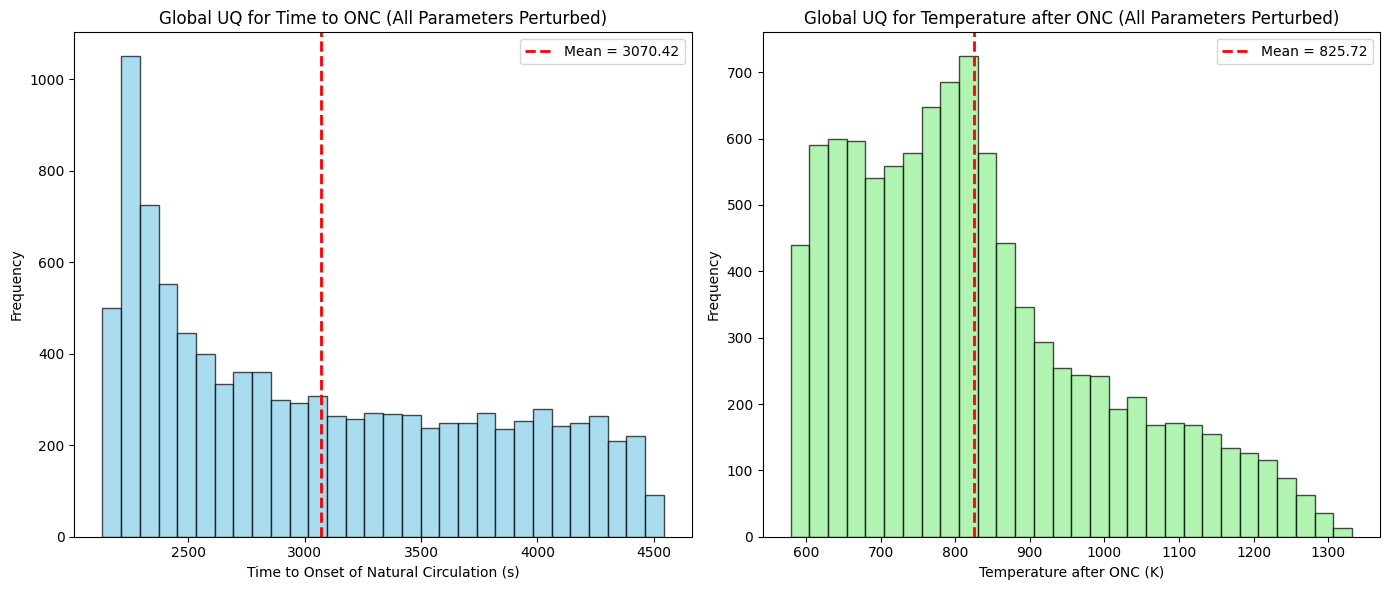

In [19]:
# =========================================
# Quantify uncertainty with the ensemble
# =========================================
# Replace: model.predict(X_scaled)
# With:     ensemble_predict_mean_std(ensemble_models, X_scaled)[0]
# Example:
global_mean_scaled, global_std_scaled = ensemble_predict_mean_std(ensemble_models, global_samples)
global_uq_ensemble = scaler_y_nn.inverse_transform(global_mean_scaled)
global_uq_ensemble_std = global_std_scaled * (1.0 / scaler_y_nn.scale_)

#---------------------------------
#UQ postprocessing
#---------------------------------

# Compute means
global_ensemble_means = global_uq_ensemble.mean(axis=0)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# global UQ time ONC
axs[0].hist(global_uq_ensemble[:, 0], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axs[0].axvline(global_ensemble_means[0], color='red', linestyle='--', linewidth=2, label=f'Mean = {global_ensemble_means[0]:.2f}')
axs[0].set_title('Global UQ for Time to ONC (All Parameters Perturbed)')
axs[0].set_xlabel('Time to Onset of Natural Circulation (s)')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# global UQ, T after ONC
axs[1].hist(global_uq_ensemble[:, 1], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axs[1].axvline(global_ensemble_means[1], color='red', linestyle='--', linewidth=2, label=f'Mean = {global_ensemble_means[1]:.2f}')
axs[1].set_title('Global UQ for Temperature after ONC (All Parameters Perturbed)')
axs[1].set_xlabel('Temperature after ONC (K)')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# Layout
plt.tight_layout()
plt.savefig(f'{output_dir}/uq_hist_ensemble.png', dpi=300, bbox_inches='tight')
plt.show()

